## Introduction and Data Sourcing

We are currently experiencing the largest refugee crisis that we have globally seen [1]. Over the past decade, the number of refugees and displaced persons has skyrocketed, and it is imperitive that services to support these individuals are in place throughout the relocation process. Importantly, services must be specified to the individual and family level so the we are correctly assisting those who require it. Using historical trends, we can better understand the demographics of displaced individuals. 

Data Science and Machine Learning are powerful tools that are often weaponized against marginalized communities [6]. Despite this history, they can also be used to help generate equity through systematic learnings when applied in the right situations. This tool is an example of one that can and should be used for justice among displaced populations. However, the technology associated with any tool using this technology can be used for bad, so we must critically understand what the technology is used for, not just what the intentionality of the technology itself is. For further reading within the realm of how data science has resulted in positive change among systems supporting refugees within the resettlement process, please see the landmark study published by Bansak, *et al.* [7]. 

The United Nations Refugee Agency (UNHCR) collects demographic data around persons of concern [2]. We can utilize this data to look at the different number of individuals from countries and locations by age and sex. This will better the ability for non-profits and humanitarian organizations to plan their services strategically to benefit the most individuals. For example, they will have a better idea as to how many women-specific and early-age development programs are needed. Having an understanding of where individuals are coming from will also better the ability to plan language integration services, job planning and relocation within specific communities.

Specifically, this tool will provide demographic trends given a specific country of origin (or total numbers across a specific group of countries) and demographic (sex/age range). Data insights will be provided temporally through digestible visuals.

It is important to note that data is split into total numbers according to sex and age ranges in this dataframe. Not only could the data collection process be improved by publically providing specific numbers for each specific age by UNHCR, but also accounting for non-binary and genderqueer populations, as they are historically marginalized moreso than the general population, so having systems to support these individuals is paramount.

In [50]:
# import libraries

import pandas as pd
import numpy as np
import pdb
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import folium
from folium.plugins import HeatMap


## Pre-processing of data

In [51]:
# pre-processing of data

# data: http://popstats.unhcr.org/en/demographics
import_path = './unhcr_popstats_export_demographics_2019_12_23_152351.csv'
demographics_df = pd.read_csv(import_path, header = 2)

demographics_df.head()


,Year,Country / territory of asylum/residence,Location Name,Female 0-4,Female 5-11,Female 5-17,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,Male 0-4,Male 5-11,Male 5-17,Male 12-17,Male 18-59,Male 60+,M: Unknown,M: Total
0,2001,Afghanistan,West,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0
1,2001,Afghanistan,Various,14335,NaN,45451.0,NaN,99880,19234,412004.0,590904,14716,NaN,47522.0,NaN,114965,13025,435492.0,625720
2,2001,Afghanistan,North,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0
3,2001,Afghanistan,Kabul,NaN,NaN,1.0,NaN,1,NaN,0.0,2,NaN,NaN,0.0,NaN,2,NaN,0.0,2
4,2001,Afghanistan,Herat,NaN,NaN,0.0,NaN,1,NaN,0.0,1,NaN,NaN,0.0,NaN,1,NaN,0.0,1


In [52]:
# Cleaning data

# convert ages to integers because you can't have half of a person
# assuming that all '*' values are 0
def clean_convert_unhcr_data(col):
    '''Clean mislabeled data for demographic levels
    '''
    demographics_df[col] = demographics_df[col].fillna(0).replace('*', 0).astype(int)

# The 'total' columns are sums of all other columns for each gender, but there is overlap among a few columns
def add_cols(col, col_list):
    '''Coalesce demographics with overlapping data
    '''
    demographics_df[col] = demographics_df[col_list].sum(axis = 1)
    
    
demographics_columns = ['Female 0-4','Female 5-11','Female 5-17','Female 12-17',
                        'Female 18-59','Female 60+','F: Unknown','F: Total',
                        'Male 0-4','Male 5-11','Male 5-17','Male 12-17',
                        'Male 18-59','Male 60+','M: Unknown','M: Total']

for col in demographics_columns:
    clean_convert_unhcr_data(col)
    
# Add columns to clean inconsistencies in data tabulation - until 2005, Female 5-11 and Female 12-17 were not two separate categories
add_cols('Female 5-17',['Female 5-11','Female 5-17','Female 12-17'])
add_cols('Male 5-17',['Male 5-11','Male 5-17','Male 12-17'])

# Dropping columns after adding together, dropping location name as this project is tailored
# to the country level
cols_to_drop = ['Female 5-11', 'Female 12-17', 'Male 5-11', 'Male 12-17','Location Name']

demographics_df = demographics_df.drop(cols_to_drop, axis = 1)
demographics_df = demographics_df.groupby(['Year','Country / territory of asylum/residence']).sum().reset_index()

# find countries with only one entry as you can't make a regression off of one entry
for country in demographics_df['Country / territory of asylum/residence'].unique():
    count = demographics_df[demographics_df['Country / territory of asylum/residence'] == country]['Country / territory of asylum/residence'].count()
    if count == 1:
        demographics_df = demographics_df[demographics_df['Country / territory of asylum/residence'] != country]
        
# Must rename some countries so that they can be geographically located for visualization
country_replacement_dictionary = {'Central African Rep.': 'Central African Republic',
                                  'China, Hong Kong SAR': 'Hong Kong', 
                                  'China, Macao SAR': 'Macao', 
                                  'Czech Rep.': 'Czech Republic',
                                  'Dem. Rep. of the Congo': 'Democratic Republic of the Congo', 
                                  'Dominican Rep.': 'Dominican Republic', 
                                  'Georgia' : 'Republic of Georgia',
                                  'Iran (Islamic Rep. of)': 'Iran', 
                                  'Micronesia (Federated States of)': 'Micronesia',
                                  'Rep. of Korea': 'Republic of Korea', 
                                  'Rep. of Moldova': 'Republic of Maldova', 
                                  'Serbia and Kosovo (S/RES/1244 (1999))': 'Serbia and Kosovo', 
                                  'Sint Maarten (Dutch part)': 'Sint Maarten',
                                  'Syrian Arab Rep.': 'Syrian Arab Republic', 
                                  'United Rep. of Tanzania': 'United Republic of Tanzania'
                                 }

for incorrect_name, correct_name in country_replacement_dictionary.items():
    demographics_df = demographics_df.replace(incorrect_name, correct_name)


## Functions Assignment

In [53]:
def specify_country(dataframe_input, country):
    '''This is utilized to filter a dataset across all countries to one specific one.
    '''
    dataframe_output = dataframe_input[dataframe_input['Country / territory of asylum/residence'] == country]
    return dataframe_output
    
def lin_reg(dataframe_input, demographic, test_size):
    '''This builds the linear regression model for a specific dataset. 
    First it converts x and y data to numpy arrays and then creates a linear regression model.
    '''
    
    x_data = country_specified_dataframe['Year'].values.reshape(-1, 1)
    y_data = country_specified_dataframe[demographic].values.reshape(-1, 1)
    
    # create training and testing datasets, pick a small test_size as there isn't a lot of data
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = test_size)

    # create linear regression object
    lr = linear_model.LinearRegression()
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    
    linear_regression_list = [lr.coef_[0][0], lr.intercept_[0], test_size, r2_score(y_test, y_pred)]

    return linear_regression_list


def get_max_r_squared(dataframe_input, demographic, country):
    '''This is used to iterate over different test_sizes for train/test/split such that we can get a max R squared value.
    '''
    
    cols_max_r2 = ['coefficient', 'intercept', 'test_size','r_squared']
    appended_data = []
    # can't go higher than 0.3, otherwise not enough data is in the fitting process
    test_size_range = np.linspace(0.01, 0.3, 100, endpoint = False) 

    for i in test_size_range:
        appended_data.append(lin_reg(dataframe_input = dataframe_input, demographic = demographic, test_size = i))
    
    r2_df = pd.DataFrame(appended_data, columns = cols_max_r2)

    # get max value for R^2, if there is more than one pull duplicates are coming from when there is no statistical 
    # trend and therefore R^2 = 1.0
    max_r2 = r2_df[r2_df['r_squared'] == r2_df['r_squared'].max()].reset_index(drop = True).iloc[:1]
    max_r2['demographic'] = demographic
    max_r2['country'] = country
    max_r2 = max_r2[['country','demographic', 'coefficient', 'intercept', 'test_size', 'r_squared',]]
    return max_r2


In [54]:
# test the return of a single country and demographic input

country_input, demographic = 'Cambodia', 'Female 5-17'

country_specified_dataframe = specify_country(demographics_df, country_input)
get_max_r_squared(country_specified_dataframe, demographic, country_input)


,country,demographic,coefficient,intercept,test_size,r_squared
0,Cambodia,Female 5-17,-1.3535,2739.732,0.1608,0.685018


In [55]:
# test list of countries
test_country_list_df = pd.DataFrame({'country': ['Samoa', 'Iceland', 'Afghanistan', 'Rep. of Korea', 'Burkina Faso', 'Bosnia and Herzegovina']})
test_country_list = test_country_list_df['country']

# full list of countries
full_country_list = demographics_df['Country / territory of asylum/residence'].sort_values().unique()

# full list of demographics
demographics_list = pd.DataFrame({'demographic': ['Female 0-4', 
                                                  'Female 5-17', 
                                                  'Female 18-59', 
                                                  'Female 60+', 
                                                  'Male 0-4', 
                                                  'Male 5-17', 
                                                  'Male 18-59', 
                                                  'Male 60+',
                                                 ]})


cols_final_df = ['country','demographic','coefficient','intercept','test_size','r_squared']
lin_reg_list =[]

# iterate over each country and demographic in dataframes
for country in full_country_list:
    for demographic in demographics_list['demographic']:
        country_specified_dataframe = specify_country(demographics_df, country)
        lin_reg_object = get_max_r_squared(country_specified_dataframe, demographic, country)
        lin_reg_list.append(lin_reg_object)
        
overall_lin_reg_df = pd.concat(lin_reg_list, ignore_index = True)

# sort countries and demographic
overall_lin_reg_df = overall_lin_reg_df.sort_values(by = ['country', 'demographic']).reset_index(drop = True)

overall_lin_reg_df.to_csv('./regression_values_overall.csv', index = False)
overall_lin_reg_df.head(10)


,country,demographic,coefficient,intercept,test_size,r_squared
0,Afghanistan,Female 0-4,8079.435748,-1.612327e+07,0.1637,0.701679
1,Afghanistan,Female 18-59,2370.113714,-4.366064e+06,0.1376,0.001657
2,Afghanistan,Female 5-17,11250.623068,-2.231182e+07,0.1144,0.528020
3,Afghanistan,Female 60+,-1236.826967,2.530553e+06,0.1057,0.667793
4,Afghanistan,Male 0-4,7517.594381,-1.498774e+07,0.0680,0.734786
5,Afghanistan,Male 18-59,-4051.029913,8.571227e+06,0.1608,0.203710
6,Afghanistan,Male 5-17,11511.010646,-2.280907e+07,0.1898,0.566234
7,Afghanistan,Male 60+,-137.902439,3.236922e+05,0.0100,0.000000
8,Albania,Female 0-4,22.445013,-4.501514e+04,0.0680,0.941958
9,Albania,Female 18-59,93.257385,-1.869692e+05,0.0709,0.971397


## Data Visualization

In [56]:
# The generation of the overall linear regression dataframe takes awhile to run, 
# so we can just load it in for time's sake

input_path = './regression_values_overall.csv'
overall_table_regression = pd.read_csv(input_path)

overall_table_regression.head()

,country,demographic,coefficient,intercept,test_size,r_squared
0,Afghanistan,Female 0-4,8079.435748,-1.612327e+07,0.1637,0.701679
1,Afghanistan,Female 18-59,2370.113714,-4.366064e+06,0.1376,0.001657
2,Afghanistan,Female 5-17,11250.623068,-2.231182e+07,0.1144,0.528020
3,Afghanistan,Female 60+,-1236.826967,2.530553e+06,0.1057,0.667793
4,Afghanistan,Male 0-4,7517.594381,-1.498774e+07,0.0680,0.734786


In [104]:
# set size of figure
plt.rcParams["figure.figsize"] = [15, 10]

def prediction_visualization(regression_calculated_dataframe, raw_dataframe_input, country_user_input, demographic_user_input, year_user_input):
    '''This plots the historical data, predictive trendline and predicted plot point based on user input year
    '''

    # locate slice from dataframe via index
    user_input_slice = regression_calculated_dataframe[(regression_calculated_dataframe['country'] == country_user_input) & 
                                                       (regression_calculated_dataframe['demographic'] == demographic_user_input)].reset_index(drop = True)

    coefficient = user_input_slice.at[0, 'coefficient']
    intercept = user_input_slice.at[0, 'intercept']


    tabulated_data = raw_dataframe_input[raw_dataframe_input['Country / territory of asylum/residence'] == country_user_input][['Year', demographic_user_input]]

    x_pred = np.linspace(2000, 2040, 41)
    y_pred = (coefficient * x_pred) + intercept
    predicted_data = pd.DataFrame({'Year': x_pred, demographic_user_input: (coefficient * x_pred) + intercept})

    # Plot Data
    fig, ax = plt.subplots()
    
    plt.scatter('Year', demographic_user_input, data = tabulated_data, c = '#CD1E16', alpha = 0.5)
    plt.scatter(year_user_input, (coefficient * year_user_input) + intercept, s = 125, c = '#530AB0')
    plt.plot('Year', demographic_user_input, data = predicted_data, c = '#530AB0')

    # label predicted point
    label = '({} , {})'.format(year_user_input, int(round((coefficient * year_user_input) + intercept)))
    plt.annotate(label,
                 (year_user_input, (coefficient * year_user_input) + intercept),
                 textcoords = "offset points",
                 xytext = (0, -30),
                 ha = 'center',
                )

    # set title, axes, legend
    plt.title('Displaced Persons from {} for the Demographic {}'.format(country_user_input, demographic_user_input), 
              fontsize = 20)
    plt.xlabel('Year', fontsize = 15, labelpad = 20)
    plt.ylabel('Number of Displaced People', fontsize = 15, labelpad = 20)
    
    plt.legend(('Predictive Data', 'Historical Data'))

    plt.show()
    
    # set predicted statement
    if ((coefficient * year_user_input) + intercept) < 0:
        print('The total number of displaced people in {} will be {}'.format(year_user_input, 0))
    else:
        print('The total number of displaced people in {} will be {}'.format(year_user_input, int(round((coefficient * year_user_input) + intercept))))
    
    
def do_geocode(address):
    '''Recursive function to pull location data associated with address input
    '''
    
    # set geolocator object
    geolocator = Nominatim(user_agent = 'GeoNames')
    
    try:
        location = geolocator.geocode(address)
        return np.array([address, location.latitude, location.longitude])
    except GeocoderTimedOut:
        return do_geocode(address)

def generate_map(dataframe, demographic, year):
    # it's not plotting all of the points (ukraine, turkmenistan, etc. dataframe input has correct lat/lng)
    '''This plots a logarithmically scale of the number of displaced people from each country in the dataframe,
    with a scale of blue (few displaced individuals) to red (many displaced individuals)
    '''

    map_df = dataframe[dataframe['demographic'] == demographic]


    displacement_map = folium.Map([37.421000, 15.087858], 
                                  zoom_start = 2,
                                  tiles = 'CartoDB dark_matter')

    for index, row in map_df.iterrows():

        prediction = (row['coefficient'] * year) + row['intercept']
        popup_text = '{}, {}: {}'.format(row['country'], year, str(int(round((row['coefficient'] * year) + row['intercept']))))

        # logarithmic scale of color markers
        if 0 <= prediction < 10:
            folium.CircleMarker(location = (row['latitude'], row['longitude']), 
                            color = '#01007A', 
                            popup = folium.Popup(popup_text, parse_html = True),
                            fill = True, 
                            fill_opacity = 0.7,
                            radius = 3
                           ).add_to(displacement_map)    

        elif 10 <= prediction < 100:
            folium.CircleMarker(location = (row['latitude'], row['longitude']), 
                            color = '#2A006D', 
                            popup = folium.Popup(popup_text, parse_html = True),
                            fill = True, 
                            fill_opacity = 0.7,
                            radius = 3.33
                           ).add_to(displacement_map)   

        elif 100 <= prediction < 1000:
            folium.CircleMarker(location = (row['latitude'], row['longitude']), 
                            color = '#540161', 
                            popup = folium.Popup(popup_text, parse_html = True),
                            fill = True, 
                            fill_opacity = 0.7,
                            radius = 3.66
                           ).add_to(displacement_map)  

        elif 1000 <= prediction < 10000:
            folium.CircleMarker(location = (row['latitude'], row['longitude']), 
                            color = '#7E0255', 
                            popup = folium.Popup(popup_text, parse_html = True),
                            fill = True, 
                            fill_opacity = 0.7,
                            radius = 4
                           ).add_to(displacement_map)  

        elif 10000 <= prediction < 100000:
            folium.CircleMarker(location = (row['latitude'], row['longitude']), 
                            color = '#A70249', 
                            popup = folium.Popup(popup_text, parse_html = True),
                            fill = True, 
                            fill_opacity = 0.7,
                            radius = 4.33
                           ).add_to(displacement_map) 

        elif 100000 <= prediction < 1000000:
            folium.CircleMarker(location = (row['latitude'], row['longitude']), 
                            color = '#D1033D', 
                            popup = folium.Popup(popup_text, parse_html = True),
                            fill = True, 
                            fill_opacity = 0.7,
                            radius = 4.66
                           ).add_to(displacement_map)

        elif 1000000 <= prediction < 10000000:
            folium.CircleMarker(location = (row['latitude'], row['longitude']), 
                            color = '#FB0431', 
                            popup = folium.Popup(popup_text, parse_html = True),
                            fill = True, 
                            fill_opacity = 0.7,
                            radius = 5
                           ).add_to(displacement_map) 
            
    return displacement_map
    

In [58]:
# build list of latitudes and longitudes for each country in dataframe
appended_list = [] 
for country in overall_table_regression['country'].unique():
    geocode = do_geocode(country)
    appended_list.append(geocode)
    

cols_appended = ['country', 'latitude', 'longitude']
appended_df = pd.DataFrame(appended_list, columns = cols_appended)

overall_table_regression = overall_table_regression.merge(appended_df, how = 'left', on = 'country')

# The generation of getting lat / lng takes awhile to run, so we can just load it in for time's sake
overall_table_regression.to_csv('./dataframe_with_lat_lng.csv', index = False)


In [63]:
input_path = './dataframe_with_lat_lng.csv'
overall_table_regression = pd.read_csv(input_path)

overall_table_regression.head()


,country,demographic,coefficient,intercept,test_size,r_squared,latitude,longitude
0,Afghanistan,Female 0-4,8079.435748,-1.612327e+07,0.1637,0.701679,33.768006,66.238514
1,Afghanistan,Female 18-59,2370.113714,-4.366064e+06,0.1376,0.001657,33.768006,66.238514
2,Afghanistan,Female 5-17,11250.623068,-2.231182e+07,0.1144,0.528020,33.768006,66.238514
3,Afghanistan,Female 60+,-1236.826967,2.530553e+06,0.1057,0.667793,33.768006,66.238514
4,Afghanistan,Male 0-4,7517.594381,-1.498774e+07,0.0680,0.734786,33.768006,66.238514


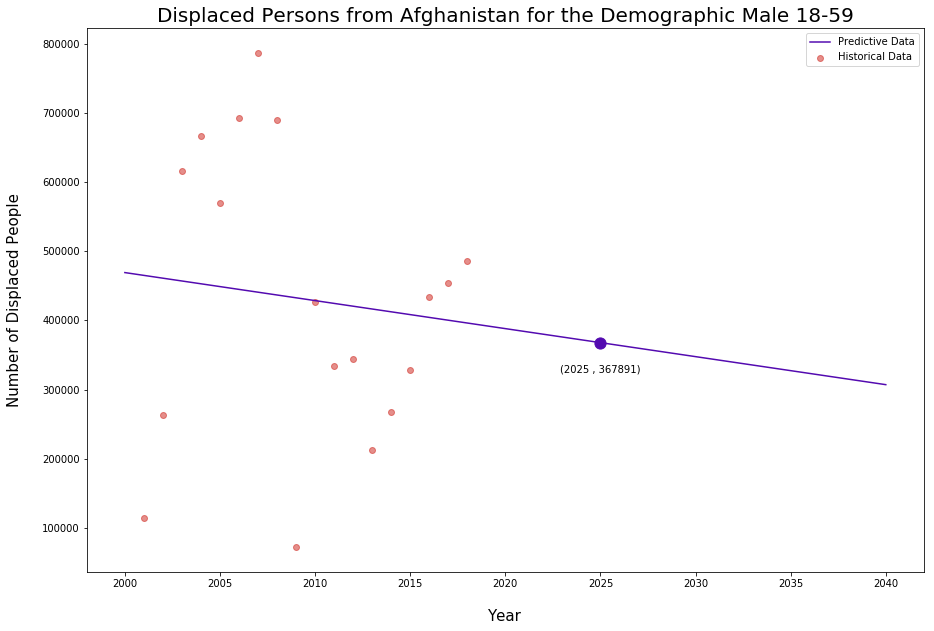

The total number of displaced people in 2025 will be 367891


In [111]:
prediction_visualization(overall_table_regression, demographics_df, 'Afghanistan', 'Male 18-59', 2025)

generate_map(overall_table_regression, 'Female 5-17', 2025)


In [281]:
# import ipywidgets as widgets

# options_years = np.linspace(2020, 2050, 51, dtype = int)

# options_answers = ('Female 0-4', 
#                    'Female 5-17', 
#                    'Female 18-59',  
#                    'Female 60+',  
#                    'Male 0-4', 
#                    'Male 5-17', 
#                    'Male 18-59', 
#                    'Male 60+',
#                   )
# dropdown_demographic = widgets.Dropdown(options = options_answers)
# dropdown_year = widgets.Dropdown(options = options_years)

# display(dropdown_demographic)
# display(dropdown_year)

Dropdown(options=('Female 0-4', 'Female 5-17', 'Female 18-59', 'Female 60+', 'Male 0-4', 'Male 5-17', 'Male 18…

Dropdown(options=(2020, 2020, 2021, 2021, 2022, 2023, 2023, 2024, 2024, 2025, 2026, 2026, 2027, 2027, 2028, 20…

## Results and Conclusion

Based on the logarithmic map that details predicted numbers of displaced people, it is clearly consistent with what we have been seeing. Specifically, the largest populations are predicted to come generally from Sub-Saharan Africa, the Middle East, Central America and parts of Southeast Asia. 

Some unexpected countries are seeing high numbers that we wouldn't expect. For example, the model predicts a very large number from Germany. However, upon a brief search, it is clear that many displaced individuals have been going to Germany in recent years, but the German government has also been deporting a large number of them. It is also geographically close to many areas that are experiencing refugee crises, such that families would go to Germany as a temporary station until moving elsewhere.

I originally intended to build a model to which we could better predict the number of specific demographics of individuals displaced in total population size to better prepare for necessary services to support refugees and other displaced persons (see definitions of these terms in [5]). That way, individuals could be provided ample aid in a much more specific way. 

The biggest downfall of this study is the predictive ability with the amount of data available. Each country has a maximum of 18 data points, one per year since 2001. With this small amount of data and the incredibly volatile nature of displacement, the actual predictive viability of this tool is very low - if anything it can only provide directional answers as to where we will be seeing displacement by specific demographics. Each time the regression is run, the $R^{2}$ varies widely among separate runs, despite being run through a maximization function. This is in addition to the fact that there are an incredible difference in the number displaced people between countries, which adds astronomically to the variance. As more data and specific data is available, this model could provide better predictive algorithms.

An area of improvement for the predicitive capability of this tool is mapping against specific trends where the causes are not as variable. It makes sense, for example, to utilize the massive amount of predictive data around climate change, which is already forcibly displacing individuals, rather than trying to predict if specific wars will break out. That isn't to say that the latter is less or more important, but that if the model intelligently pulls in causal factors in addition to predicting exclusively based on historical trends of total population movement, the model would be better equipped in a predictive capacity. In essence, machine learning is complex, and displacement trends are even more complex, so getting usable information requires much more than simple linear regression. However, this could provide a scaffold for loading, cleaning and transforming complex datasets to build and analyze necessary learning algorithms.



#### References:

#### [1]: https://www.unhcr.org/blogs/statistics-refugee-numbers-highest-ever/
#### [2]: http://popstats.unhcr.org/en/demographics
#### [3]: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
#### [4]: https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916
#### [5]: https://www.unhcr.org/ph/persons-concern-unhcr
#### [6]: https://www.amazon.com/Weapons-Math-Destruction-Increases-Inequality/dp/0553418815
#### [7]: https://science.sciencemag.org/content/359/6373/325/tab-pdf